In [44]:
import os
import gc, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [45]:
def feature_engineering(is_train=True,debug=True):
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('test_V2.csv')
    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
 
#     df['headshotrate'] = df['kills']/df['headshotKills']
#     df['killStreakrate'] = df['killStreaks']/df['kills']
#     df['healthitems'] = df['heals'] + df['boosts']
#     df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
#     df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
#     df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
#     df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
#     df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
#     df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
#     df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
#     df["skill"] = df["headshotKills"] + df["roadKills"]

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    y = None
    
    if is_train: 
        print("get target")
        y = df.groupby(['matchId','groupId'])[target].agg('mean')
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y

In [46]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [47]:
x_train, y_train = feature_engineering(True,False)
x_test, _ = feature_engineering(False,True)

processing train.csv
remove some columns
Adding Features
Removing Na's From DF
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
processing test.csv
remove some columns
Adding Features
Removing Na's From DF
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
Xtrain, Xtest, yTrain, yTest = train_test_split(x_train, y_train, shuffle=False)
std_scaler = StandardScaler().fit(Xtrain)
Xtrain = std_scaler.transform(Xtrain)
Xtest = std_scaler.transform(Xtest)

model = LinearRegression()
model.fit(Xtrain, yTrain)
pred = model.predict(Xtest)
print(mean_absolute_error(pred, yTest))

0.04960561007640552


In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

yTrain = yTrain.astype(int)
model = LinearDiscriminantAnalysis()
model.fit(Xtrain, yTrain)
pred = model.predict(Xtest)
print(mean_absolute_error(pred, yTest))


/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.46874262995227806


In [27]:
def nn_model(input_shape=x_train.shape[1], hidden_size=128):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_shape, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
    model.add(Dense(hidden_size, kernel_initializer='xavier'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer='xavier'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    return model

In [8]:
def train_val_split(x_train, y_train):
    train_index = round(int(x_train.shape[0]*0.8))
    dev_X = x_train[:train_index] 
    val_X = x_train[train_index:]
    dev_y = y_train[:train_index] 
    val_y = y_train[train_index:]
    return dev_X, val_X, dev_y, val_y

In [33]:
np.random.seed(42)

std_scaler = StandardScaler().fit(x_train)
x_train = std_scaler.transform(x_train)
x_test = std_scaler.transform(x_test)

mlp_model = nn_model(x_train.shape[1], hidden_size=64)
history = mlp_model.fit(x_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.1, shuffle=True)
pred_test_mlp = mlp_model.predict(x_test)

/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Train on 1824069 samples, validate on 202675 samples
Epoch 1/8
1824069/1824069 [==============================] - 44s 24us/step - loss: 0.0619 - mean_absolute_error: 0.0619 - val_loss: 0.0541 - val_mean_absolute_error: 0.0541
Epoch 2/8
1824069/1824069 [==============================] - 43s 23us/step - loss: 0.0535 - mean_absolute_error: 0.0535 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 3/8
1824069/1824069 [==============================] - 43s 24us/step - loss: 0.0521 - mean_absolute_error: 0.0521 - val_loss: 0.0500 - val_mean_absolute_error: 0.0500
Epoch 4/8
1824069/1824069 [==============================] - 44s 24us/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 5/8
1824069/1824069 [==============================] - 43s 24us/step - loss: 0.0510 - mean_absolute_error: 0.0510 - val_loss: 0.0513 - val_mean_absolute_error: 0.0513
Epoch 6/8
1824069/1824069 [==============================] - 44s 24us/step - loss:

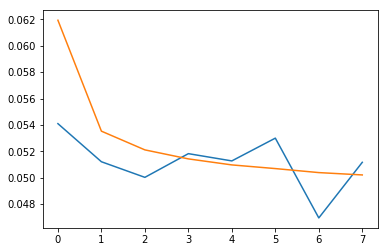

In [34]:
plt.plot(history.history['val_loss']);
plt.plot(history.history['loss']);